In [9]:
import numpy as np
import scanpy as sc
import anndata as ad
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
PTH = "/home/alma/w-projects/sploc/data/visium/bc2/"
adata = sc.read_visium(PTH)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


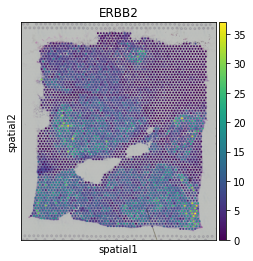

In [68]:
sc.pl.spatial(adata,color=["ERBB2"],size  = 1)

In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [6]:
sc.pp.normalize_per_cell(adata,1e4)
sc.pp.log1p(adata)
n_clusters = 10
km = KMeans(n_clusters = n_clusters)
pca = PCA(n_components=20)
X = np.array(adata.X.todense())
Y = pca.fit_transform(X.T)
cidx = km.fit_predict(Y)

/home/alma/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
X_new = np.zeros((X.shape[0],n_clusters))
for c in range(n_clusters):
    X_new[:,c] = X[:,cidx == c].mean(axis=1)

In [10]:
adata2 = ad.AnnData(X_new,
                   obs = adata.obs,
                    var = pd.DataFrame(["MG{}".format(x) for x in range(n_clusters)],
                                      index = ["MG{}".format(x) for x in range(n_clusters)],
                                       columns = ["metagene"]
                                      )
                   )

adata2.obsm["spatial"] = adata.obsm["spatial"]
adata2.uns = adata.uns

In [ ]:
adata2.var

In [11]:
sc.pl.spatial(adata2,color = ["MG{}".format(x) for x in range(n_clusters)])

KeyboardInterrupt: 

In [ ]:
n_genes = 100
img_size = 64
gene_ids = np.argsort(X.var(axis=0))[::-1][0:n_genes]
crd = adata.obsm["spatial"]
ncrd = crd - crd.min(axis=0,keepdims=True)

mx = np.max(ncrd)
ncrd = ncrd / mx * (img_size)
xx = np.arange(img_size)
xx,yy = np.meshgrid(xx,xx)
xx = xx.flatten()[:,np.newaxis]
yy = yy.flatten()[:,np.newaxis]
grid = np.hstack((xx,yy))
dmat = scipy.spatial.distance.cdist(ncrd,grid)
dmat[dmat==0] = np.inf
min_pos = np.argmin(dmat,axis=1)
xv = np.zeros((img_size,img_size,n_genes))
for g in range(n_genes):
    for s in range(len(ncrd)):
        xp,yp = grid[min_pos[s],:]
        xv[xp,yp,g] = X[s,gene_ids[g]]
    
    mx =  xv[:,:,g].max()
    mn =  xv[:,:,g].min()
    q_l = np.quantile(xv[:,:,g],0.05)
    q_u = np.quantile(xv[:,:,g],0.95)
    xv[xv[:,:,g] > q_u,g] = q_u
    xv[:,:,g] =  (xv[:,:,g] - mn) / (mx-mn)


In [13]:
img_size = 64
crd = adata2.obsm["spatial"]
ncrd = crd - crd.min(axis=0,keepdims=True)

mx = np.max(ncrd)
ncrd = ncrd / mx * (img_size)
xx = np.arange(img_size)
xx,yy = np.meshgrid(xx,xx)
xx = xx.flatten()[:,np.newaxis]
yy = yy.flatten()[:,np.newaxis]
grid = np.hstack((xx,yy))
dmat = scipy.spatial.distance.cdist(ncrd,grid)
dmat[dmat==0] = np.inf
min_pos = np.argmin(dmat,axis=1)
xv = np.zeros((img_size,img_size,n_clusters))
for g in range(n_clusters):
    for s in range(len(ncrd)):
        xp,yp = grid[min_pos[s],:]
        xv[xp,yp,g] = X_new[s,g]
    
    mx =  xv[:,:,g].max()
    mn =  xv[:,:,g].min()
    xv[:,:,g] =  (xv[:,:,g] - mn) / (mx-mn)


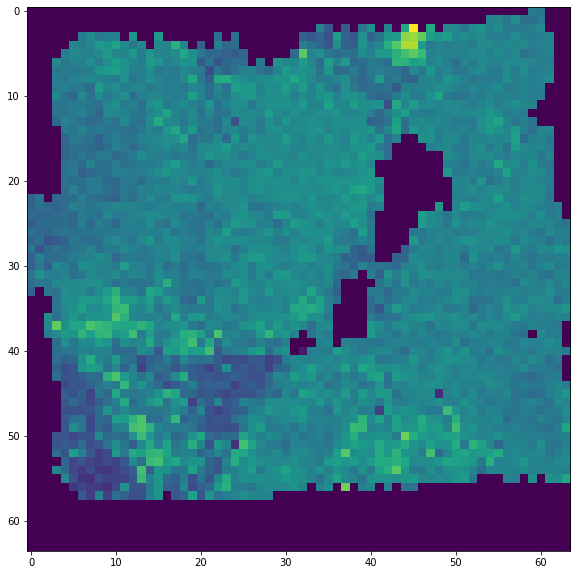

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(xv[:,:,0])
#plt.scatter(ncrd[:,0],ncrd[:,1],s=1)
#plt.scatter(grid[:,0],grid[:,1],s=1)
plt.show()

In [23]:
from __future__ import print_function, division
import os
import torch as t
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn as nn

In [ ]:
from sklearn.decomposition import PCA

In [24]:
class ImageDataset(Dataset):
    def __init__(self,
                 images,
                 transform_source,
                transform_both):
        self.images = images
        self.s_transform = transform_source
        self.b_transform = transforms_both
     
    def __len__(self,):
        return len(self.images)
    
    def __getitem__(self,idx):
        target = self.images[idx]
        target = self.b_transform(image=target)["image"].transpose(2,0,1)
        source = self.s_transform(image=target)["image"]
        
        source = t.tensor(source)
        target = t.tensor(target)
    
        
        return source,target
        

In [25]:
import albumentations as A
transforms_source = A.Compose([A.GridDistortion(border_mode = 0,
                                         num_steps=1,
                                         distort_limit=0.1,
                                         interpolation = 2,
                                         always_apply = True,
                                        ),
                          ],
                           )

transforms_both = A.Compose([
                        A.RandomRotate90(p=1),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        ])

torch.Size([10, 64, 64])
torch.Size([10, 64, 64])


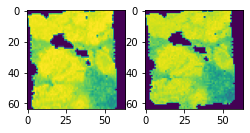

In [31]:
ds = ImageDataset([xv,xv],
                  transforms_source,
                 transforms_both,
                 )
sr,tr = ds.__getitem__(0)
print(sr.shape)
print(tr.shape)
gene = 1
plt.subplot(131)
plt.imshow(sr[gene],vmax = 1,vmin=0)
plt.subplot(132)
plt.imshow(tr[gene],vmax = 1,vmin=0)
plt.show()

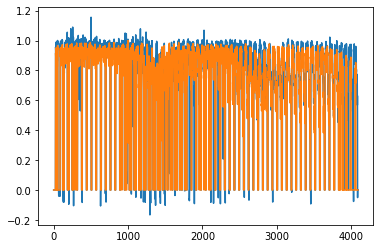

In [32]:
plt.plot(sr[gene].flatten())
plt.plot(tr[gene].flatten())

In [33]:
class GaussianHeatmap:
    def __init__(self,
                 sigma=1,
                 alpha = 1000,
                ):
        self.sigma = sigma
        self.alpha = alpha
        
    def _compute_base(self,image):
        N,C,H,W = image.shape
        sm = nn.functional.softmax((self.alpha * image).view(N,C,H*W),dim=2).view(N,C,H,W)
        xx = t.arange(W)
        yy = t.arange(H)
        xx,yy = t.meshgrid(xx,yy)
        _x = t.sum(xx * sm,
                   dim=(2,3)).view(N,C,1,1)
        _y = t.sum(yy * sm,
                   dim=(2,3)).view(N,C,1,1)
        
        return (xx,yy,_x,_y)
    
    def get_coordinate(self,image):
        _,_,_x,_y = self._compute_base(image)
        return _x,_y
        
    def __call__(self,image):
        xx,yy,_x,_y = self._compute_base(image)
        hm = t.exp(-((xx-_x)**2 + (yy-_y)**2) / 2 / self.sigma**2)
        
        return hm

In [ ]:
ghm = GaussianHeatmap(1)
plt.imshow(tr.reshape(1,2,64,64)[0,0,:,:])
plt.imshow(ghm(tr.reshape(1,2,64,64))[0,0,:,:],cmap = plt.cm.Reds,alpha = .6)


In [62]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,
                 init_channels,
                 n_landmarks = 4,
                ):
        super().__init__()
        
        self.e_conv1 = nn.Conv2d(init_channels,
                                 out_channels = 32,
                                 kernel_size=3,
                                 stride = 1,
                                 )
        
        self.e_conv2 = nn.Conv2d(in_channels = 32,
                                 out_channels= 64,
                                 kernel_size=3,
                                 stride = 1,
                                )

             
        self.e_conv3 = nn.Conv2d(in_channels = 64,
                                 out_channels= 128,
                                 kernel_size=3,
                                 stride = 1,
                                )
        
        self.l_conv4 = nn.Conv2d(in_channels=128,
                                 out_channels=n_landmarks,
                                 kernel_size=1,
                                 stride = 1,
                                )
        
        self.gaussian_heatmap = GaussianHeatmap(sigma=0.05)
        
        self.d_conv1 = nn.ConvTranspose2d(n_landmarks + 128,
                                          out_channels=64,
                                          kernel_size=1,
                                         )
        
        self.d_conv2 = nn.UpsamplingBilinear2d(size=(32,32))

        self.d_conv3 = nn.ConvTranspose2d(64,
                                          out_channels=32,
                                          kernel_size=1,
                                         )
        self.d_conv4 = nn.UpsamplingBilinear2d(size=(64,64))
        
        self.d_conv5 = nn.ConvTranspose2d(32,
                                          out_channels=init_channels,
                                          kernel_size=1,
                                         )
     

    def forward(self,source,target):
        s_em = self.l_conv4(self.e_conv3(self.e_conv2(self.e_conv1(source))))
        t_em = self.e_conv3(self.e_conv2(self.e_conv1(target)))

        s_hm = self.gaussian_heatmap(s_em)
        z = t.cat((t_em,s_hm),dim=1)
        y = self.d_conv5(self.d_conv4(self.d_conv3(self.d_conv2(self.d_conv1(z)))))

        return y
    
    def get_landmarks(self,target):
        return self.gaussian_heatmap.get_coordinate(self.l_conv4(self.e_conv3(self.e_conv2(self.e_conv1(target)))))

In [35]:
xv = xv.reshape(1,*xv.shape)
xv = xv.astype(np.float32)

In [ ]:
xv = xv.reshape(1,32,32,50)

In [36]:
trainset = ImageDataset(xv,transforms_source,transforms_both)
trainloader = t.utils.data.DataLoader(trainset,
                                      batch_size=1,
                                      shuffle=False,
                                      num_workers=2)

In [64]:
n_iter = 500
net = Net(n_clusters,
          n_landmarks = 10,)

criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(), lr=0.001,weight_decay = 5e-4)
running_loss = []

for epoch in range(n_iter):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        source, target = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(source,
                      target)
        
        loss = criterion(outputs,source)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())

print('Finished Training')

Finished Training


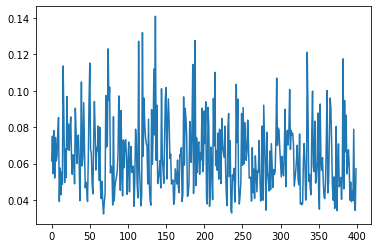

In [66]:
plt.plot(running_loss[100::])
plt.show()

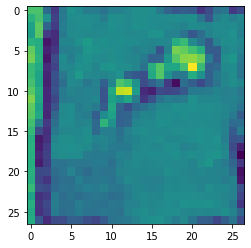

In [51]:
source,target = trainset.__getitem__(0)

target = target.view(1,*target.shape)
source = source.view(1,*source.shape)
hh = (net.e_conv3(net.e_conv2(net.e_conv1(target)))).detach()
latent_size = hh.shape[2]
plt.imshow(hh[0,0,:,:])

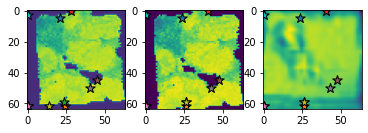

In [58]:
net.eval()
n_gene = 9
n_landmarks = 10
source,target = trainset.__getitem__(0)

target = target.view(1,*target.shape)
source = source.view(1,*source.shape)

s_x,s_y = net.get_landmarks(source)
t_x,t_y = net.get_landmarks(target)

new_crd = list()

for z in [s_x,s_y,t_x,t_y]:
    z = z.detach().numpy().flatten()
    z = z * 64 / latent_size
    new_crd.append(z)
    
s_x,s_y,t_x,t_y = new_crd 

plt.subplot(131)
plt.imshow(source.detach().numpy()[0,n_gene],alpha = 1)
for i in range(n_landmarks):
    plt.scatter(s_x[i],s_y[i],s = 100,marker = "*",edgecolor ="black")
    
plt.subplot(132)
plt.imshow(target.detach().numpy()[0,n_gene,:],alpha = 1)
for i in range(n_landmarks):
    plt.scatter(t_x[i],t_y[i],s = 100,marker = "*",edgecolor ="black")
    
plt.subplot(133)
plt.imshow(outputs.detach().numpy()[0,n_gene,:],alpha = 1)
for i in range(n_landmarks):
    plt.scatter(t_x[i],t_y[i],s = 100,marker = "*",edgecolor ="black")